<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="./src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="./src/cds-logo.jpeg">

# Data Aggregation and Correlation

Data Aggregation phase will integrates data from the same time and the same geographical references in a pandas dataset. The result will be a series of CSV files with discharges, temperatures and precipitations on a part of Italy that will be our domain of interest.

## Libraries Dependencies

In [10]:
# installation of dependencies for remote notebook (Jupyter or Google Colab)
# !pip install xarray 
# !pip install netCDF4 dask bottleneck
# !pip install pandas
# !pip install geopandas
# !pip install cdsapi
# !pip instal matplotlib
# !pip install sklearn

# installation of dependencies for local notebook
%pip install xarray 
%pip install netCDF4 dask bottleneck
%pip install pandas
%pip install geopandas
%pip install cdsapi
%pip install matplotlib
%pip install statsmodels
%pip install sklearn

You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to rest

## Integration between TPI and RDH 

In [2]:
import netCDF4
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 
from ts import adfuller, grangercausalitytests, durbin_watson, kpss
from ts import VAR
from pandas.plotting import lag_plot


In [ ]:
jsonFileR = open("./samples/map-italy-loc.json", "r") # file with the i.j indexes for the lat lon inside the north italy rectangle, saved in the same directory of coordinates
ljson = json.load(jsonFileR)
jsonFileR.close()

i_dim = 949 # index of the last element for temperature and precipitation since in a file i goes from 0 to 949 and in the other two it goes from 949 to 0

#header for the csv file
header = ['time', 'lat', 'lon', 'discharge', 'temp', 'prec']


d_years = ['2013-2014-2', '2015-2016-3', '2017-2018-4', '2019-2020-5', '2021-2022-6'] # years in the discharge file
p_t_years = ['2013-8', '2014-9', '2015-10', '2016-11', '2017-12', '2018-13', '2019-14', '2020-15', '2021-16'] # years in the temperature and precipitation file
d_years = ['2021-2022-6']
p_t_years = ['2021-16', '2022-17']
for idf_d in range(0, len(d_years)):
# Edit file path
    nc_d = netCDF4.Dataset('./samples/rdh-'+d_years[idf_d] +'.nc')
    # for each discharge file there are two yers of temperature and precipitation files, so they are indexed adding to the index of the discharge file
    for idf_d_t in range(0, 2):
        year = p_t_years[idf_d+idf_d_t]
        nc_p = netCDF4.Dataset('./samples/tpi-prec-' + year + '.nc')
        nc_t = netCDF4.Dataset('./samples/tpi-temp-' + year + '.nc')

        # variables that need to be saved, avoiding to have too many indexes later
        # the time for the timestamp is taken from the precipitation file
        time_var = nc_p.variables['time']
        dtime = netCDF4.num2date(time_var[:],time_var.units)
        discharge = nc_d.variables['dis06']
        lat = nc_d.variables['latitude']
        lon = nc_d.variables['longitude']
        temp = nc_t.variables['tasAdjust']
        prec = nc_p.variables['prAdjust']
        # for each year write the header of the csv file
        ds = pd.DataFrame(data = [], columns = header)
        ds.to_csv('italy-dtp-' + year + '.csv', mode='w', index=True)
        # for each timestamp (so for each day) create a new empty dataframe
        for l in ljson:
            ds = pd.DataFrame(data = [], columns=header)
            len_ds = len(ds)
            for t in range(0, len(dtime)):
                ds.loc[len_ds] = [dtime[t], lat[l[0]][l[1]], lon[l[0]][l[1]], discharge[t+(365*idf_d_t)][l[0]][l[1]], temp[t][i_dim-l[0]][l[1]]-273.15, prec[t][i_dim-l[0]][l[1]]]
                len_ds += 1
            # when the timestamp is done write the dataframe to the file, without the header
            ds.to_csv('italy-dtp-' + year + '.csv', mode='a', index=True, header=False)

## Initial Data Visualization

In [3]:
j = 11
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
for i in range(2016, 2019):
    tmp = pd.read_csv("samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [4]:
df.head()

,time,lat,lon,discharge,temp,prec
0,2016-01-01 12:00:00,44.750378,7.56052,3.988281,6.876062,0.0
1,2016-01-02 12:00:00,44.750378,7.56052,3.983398,5.494745,0.0
2,2016-01-03 12:00:00,44.750378,7.56052,4.030762,3.512628,0.0
3,2016-01-04 12:00:00,44.750378,7.56052,4.053223,3.912592,0.0
4,2016-01-05 12:00:00,44.750378,7.56052,4.042969,5.097375,0.0


In [5]:
df.tail()

,time,lat,lon,discharge,temp,prec
3251050,2018-12-27 12:00:00,41.23425,13.701608,0.231445,7.397058,0.000222
3251051,2018-12-28 12:00:00,41.23425,13.701608,0.202148,8.206964,0.000143
3251052,2018-12-29 12:00:00,41.23425,13.701608,0.176758,7.938043,0.000014
3251053,2018-12-30 12:00:00,41.23425,13.701608,0.154297,7.159845,0.000021
3251054,2018-12-31 12:00:00,41.23425,13.701608,0.136719,5.911279,0.0


We will analyze one of the year to estabilish possible statistics correlations between discharge with temperatures and precipitations. 

In [119]:
print('The current length of the dataframe is: {}'.format(len(df)))

The current length of the dataframe is: 9762072


In [6]:
df = df[df['lat'] == 41.23425]
df = df[df['lon'] == 13.701608]
df.head()

,time,lat,lon,discharge,temp,prec
3259596,2016-01-01 12:00:00,41.23425,13.701608,0.086914,8.761499,0.0
3259597,2016-01-02 12:00:00,41.23425,13.701608,0.085938,8.330347,0.0
3259598,2016-01-03 12:00:00,41.23425,13.701608,0.367188,7.056696,0.0
3259599,2016-01-04 12:00:00,41.23425,13.701608,0.29834,9.670282,0.000001
3259600,2016-01-05 12:00:00,41.23425,13.701608,0.381836,12.275537,0.000028


We have chosen one of the official coordinate filtered on rivers locations and try to find some correlation between this geographical position with related precipitations on 2.5 x 2.5 kms of distances.

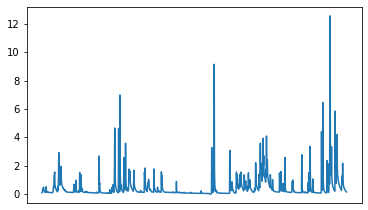

In [9]:
df_time = pd.DataFrame()
df_time['value'] = df['discharge']
df_time = df_time.set_index(df['time'])
plt.plot(df_time)
plt.gcf().autofmt_xdate()
plt.tick_params(labelbottom=False, bottom=False)
plt.show()

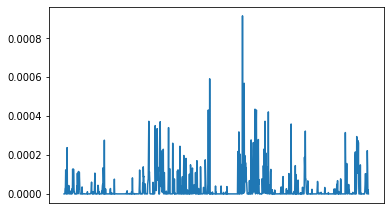

In [122]:
df_prec = pd.DataFrame()
df_prec['value'] = df['prec']
df_prec = df_prec.set_index(df['time'])
plt.plot(df_prec)
plt.gcf().autofmt_xdate()
plt.tick_params(labelbottom=False, bottom=False)
plt.show()

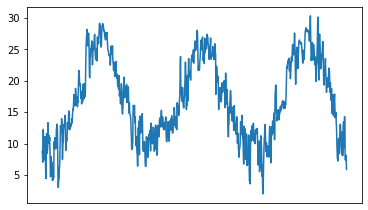

In [123]:
df_temp = pd.DataFrame()
df_temp['value'] = df['temp']
df_temp = df_temp.set_index(df['time'])
plt.plot(df_temp)
plt.gcf().autofmt_xdate()
plt.tick_params(labelbottom=False, bottom=False)
plt.show()

## Data Correlations

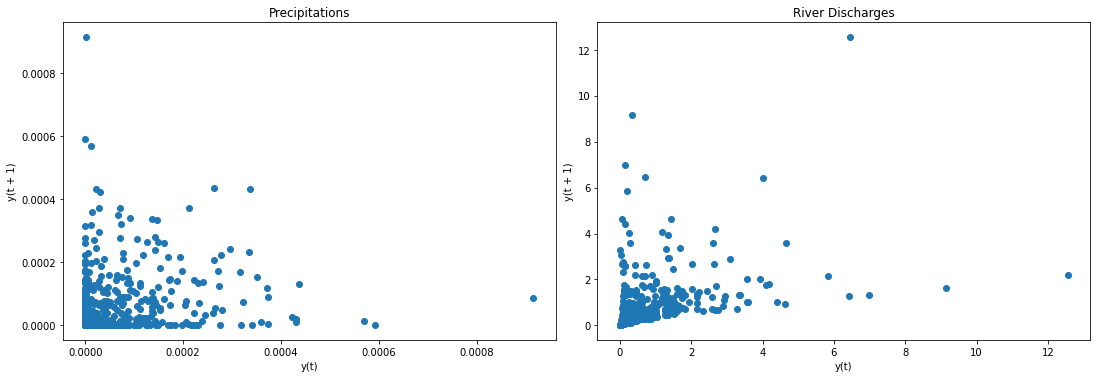

In [10]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(df['prec'], ax=ax4)
ax4.set_title('Precipitations')

lag_plot(df['discharge'], ax=ax5)
ax5.set_title('River Discharges')

plt.show()

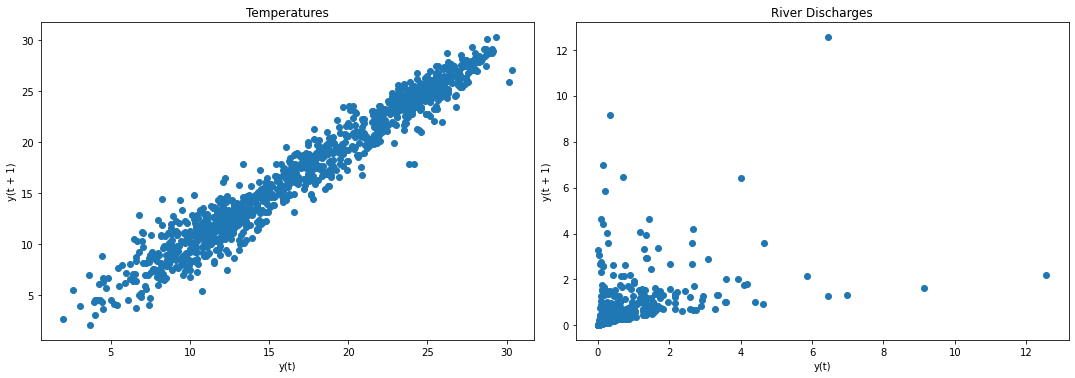

In [11]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(df['temp'], ax=ax4)
ax4.set_title('Temperatures')

lag_plot(df['discharge'], ax=ax5)
ax5.set_title('River Discharges')

plt.show()

In [7]:
rawData = df.copy(deep=True)

In [8]:
df['discharge'] = df['discharge'] - df['discharge'].shift(1)
df['prec'] = df['prec'] - df['prec'].shift(1)
data = df.dropna()

In [9]:
# split data into train and test. We will need this later for VAR analysis
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [139]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary

print('ADF on River Discharges:')
DIS = np.array(data['discharge'])
result = adfuller(DIS)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
print('ADF on Precipitations:')
PREC = np.array(data['prec'])
result = adfuller(PREC)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


print('ADF on Air Temperatures:')
TEMP = np.array(data['temp'])
result = adfuller(TEMP)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF on River Discharges:
ADF Statistic: -13.694083
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
ADF on Precipitations:
ADF Statistic: -14.715595
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
ADF on Air Temperatures:
ADF Statistic: -2.150628
p-value: 0.224650
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [140]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

print('Discharge River KPSS:\n{}'.format(kpss_test(DIS)))
print('Air Temperature KPSS:\n{}'.format(kpss_test(TEMP)))
print('Precipitations KPSS:\n{}'.format(kpss_test(PREC)))


KPSS Statistic: 0.0488372895345779
p-value: 0.1
num lags: 96
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Discharge River KPSS:
None
KPSS Statistic: 0.22465396772930518
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Air Temperature KPSS:
None
KPSS Statistic: 0.04283382789884812
p-value: 0.1
num lags: 80
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Precipitations KPSS:
None


/Users/kode/Desktop/Copernicus-river-discharges/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/kode/Desktop/Copernicus-river-discharges/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/kode/Desktop/Copernicus-river-discharges/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


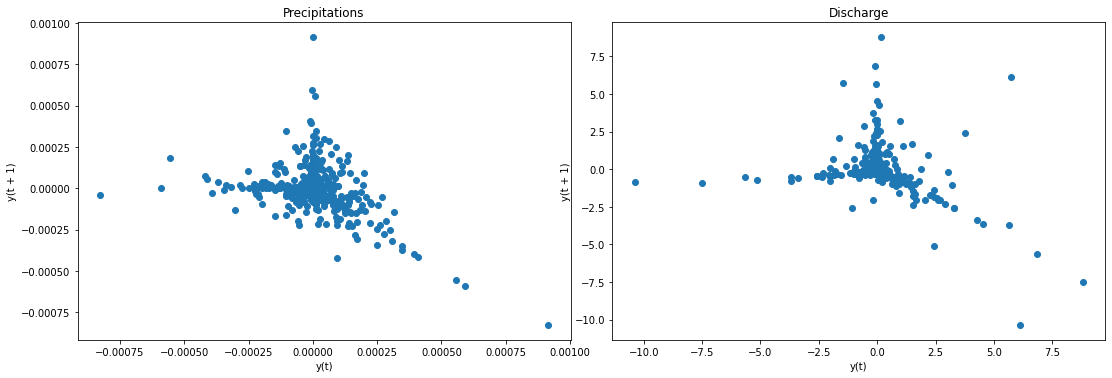

In [131]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data['prec'], ax=ax4)
ax4.set_title('Precipitations')

lag_plot(data['discharge'], ax=ax5)
ax5.set_title('Discharge')

plt.show()

In [10]:
rawData = rawData.dropna()
rawData.head()

,time,lat,lon,discharge,temp,prec
3259596,2016-01-01 12:00:00,41.23425,13.701608,0.086914,8.761499,0.0
3259597,2016-01-02 12:00:00,41.23425,13.701608,0.085938,8.330347,0.0
3259598,2016-01-03 12:00:00,41.23425,13.701608,0.367188,7.056696,0.0
3259599,2016-01-04 12:00:00,41.23425,13.701608,0.29834,9.670282,0.000001
3259600,2016-01-05 12:00:00,41.23425,13.701608,0.381836,12.275537,0.000028


In [19]:
rawData2 = rawData.copy(deep=True)
rawData2['prec'] = rawData2['prec'].astype(float)
rawData2['temp'] = rawData2['temp'].astype(float)
rawData2['discharge'] = rawData2['discharge'].astype(float)
rawData2['lat'] = rawData2['lat'].astype(float)
rawData2['lon'] = rawData2['lon'].astype(float)
rawData2['time'] = pd.to_datetime(rawData['time'], format = '%Y-%m-%d %H:%M:%S')

In [20]:
rawData2.index = rawData2.time
rawData2.drop(columns=['time'], axis=1, inplace=True)

In [21]:
# training and validation splitting 
train = rawData2[:int(0.8*(len(data)))]
valid = rawData2[int(0.8*(len(data))):]

In [221]:
# obtain the lag P for VAR
model = VAR(np.asarray(train)) # recall that rawData is w/o difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -28.452597497406888
BIC :  -28.452576098619147
FPE :  4.397379131475364e-13
HQIC:  -28.45259223991311 

Lag Order = 2
AIC :  -28.58087730701893
BIC :  -28.58083807590631
FPE :  3.867966442586772e-13
HQIC:  -28.58086766827989 

Lag Order = 3
AIC :  -28.650768668053818
BIC :  -28.650711604614727
FPE :  3.6068598309067543e-13
HQIC:  -28.650754648069107 

Lag Order = 4
AIC :  -28.697765740101953
BIC :  -28.697690844334794
FPE :  3.441269585400025e-13
HQIC:  -28.697747338871164 

Lag Order = 5
AIC :  -28.721238245402176
BIC :  -28.72114551730535
FPE :  3.3614349912135427e-13
HQIC:  -28.721215462924903 

Lag Order = 6
AIC :  -28.73229691884102
BIC :  -28.732186358412925
FPE :  3.324466765875005e-13
HQIC:  -28.732269755116853 

Lag Order = 7
AIC :  -28.744674986298744
BIC :  -28.744546593537788
FPE :  3.2835699260783534e-13
HQIC:  -28.74464344132728 

Lag Order = 8
AIC :  -28.764746514529225
BIC :  -28.764600289433808
FPE :  3.218320676235739e-13
HQIC:  -28.76471058831006

In [23]:
train

,lat,lon,discharge,temp,prec
time,,,,,
2016-01-01 12:00:00,41.23425,13.701608,0.086914,8.761499,5.680093e-09
2016-01-02 12:00:00,41.23425,13.701608,0.085938,8.330347,2.505304e-10
2016-01-03 12:00:00,41.23425,13.701608,0.367188,7.056696,3.318990e-12
2016-01-04 12:00:00,41.23425,13.701608,0.298340,9.670282,1.194141e-06
2016-01-05 12:00:00,41.23425,13.701608,0.381836,12.275537,2.754594e-05
...,...,...,...,...,...
2018-05-21 12:00:00,41.23425,13.701608,0.167969,16.623621,3.488842e-05
2018-05-22 12:00:00,41.23425,13.701608,0.155273,16.077325,1.042146e-05
2018-05-23 12:00:00,41.23425,13.701608,2.577148,15.593164,3.661671e-07


In [24]:
train = train.drop(columns=['lat','lon'])

In [25]:
# best lang = 2
model = VAR(train)
model_fitted = model.fit(2)

/Users/kode/Desktop/Copernicus-river-discharges/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [59]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(train.columns, out):
    print(col, ':', round(val, 2))

discharge : 2.01
temp : 1.96
prec : 2.02


In [32]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics
result = ts.coint(data['temp'], data['discharge'])
print(result)

(-2.1522589085549035, 0.44910153488157467, array([-3.90647889, -3.3417208 , -3.04832906]))


In [26]:
model = VAR(train)
model_fitted = model.fit(2)
# get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

2


/Users/kode/Desktop/Copernicus-river-discharges/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = lag_order #  because we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=True):    
    """Application of the Granger Causality test on data using filtered parameters given
    by the columns of the input dataframe. This function return the confusion matrix about the 
    causality relations between x and y where x (cols) causes y (rows).

    Args:
        data (pd.DataFrame): input dataframe
        variables (np.Array): array of variables related to the time series of the granger causality testing
        test (str, optional): Type of test related to the granger causality, values are internal of fixed values (ssr_ftest, ssr_chi2test, params_ftest, lrtest)
        verbose (bool, optional): Verbose mode. Defaults to False.

    Returns:
        pd.DataFrame: It is a fixed DataFrame from pandas library where the current
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)  

Y = discharge, X = discharge, P Values = [1.0, 1.0]
Y = temp, X = discharge, P Values = [0.7828, 0.5927]
Y = prec, X = discharge, P Values = [0.2961, 0.6069]
Y = discharge, X = temp, P Values = [0.0002, 0.0018]
Y = temp, X = temp, P Values = [1.0, 1.0]
Y = prec, X = temp, P Values = [0.0318, 0.0095]
Y = discharge, X = prec, P Values = [0.5136, 0.827]
Y = temp, X = prec, P Values = [0.0018, 0.0046]
Y = prec, X = prec, P Values = [1.0, 1.0]


In [28]:
print('Granger causality on chi2test:\n{}\n'.format(grangers_causation_matrix(train, variables = train.columns, verbose=False)))
print('Granger causality on lrtest:\n{}\n'.format(grangers_causation_matrix(train, variables = train.columns, test='lrtest', verbose=False)))
print('Granger causality on ssr_ftest:\n{}\n'.format(grangers_causation_matrix(train, variables = train.columns, test='ssr_ftest', verbose=False)))



Granger causality on chi2test:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0002  0.5136
temp_y            0.5927  1.0000  0.0018
prec_y            0.2961  0.0095  1.0000

Granger causality on lrtest:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0002  0.5137
temp_y            0.5928  1.0000  0.0019
prec_y            0.2962  0.0098  1.0000

Granger causality on ssr_ftest:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0002  0.5145
temp_y            0.5946  1.0000  0.0019
prec_y            0.2972  0.0100  1.0000



Final consideration about this phase is focussing on the correlation and causality-dependency between our values. In other terms, we considered possible dependency about values on one fields to each other included itself. In our experiments, we analyzed the possible features about the singular time series like stationality using ADF and KPSS tests and a possible visualization on lag plots. Finally, we executed some tests to secure about the serial residual correlation using Durbin Watson Statistics; and we didn't even have significant values. In conclusion, we have chosen the best lang according to the AIC values between 1 and 12 to fit the VAR model and we didn't modified the max lang because it was the same of the chosen one for the granger causality final test. Into the Granger Causality matrices, we can check possible causality-dependency: Precipitations and temperatures are cointegrated, so we can't consider their relation due to the mutual correlation; precipitation accepted the null-hypothesis on the maxlang p-value which is greater than 0.05, meanwhile temperatures rejected it (p_value = 0.002).